In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Database connection configuration
config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'root',
    'database': 'spherych_devapp'
}

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Step 1: Understand the current database structure
def analyze_database_structure():
    """
    Analyze how game modes and exercises are currently stored in the database
    """
    try:
        conn = mysql.connector.connect(**config)
        print("Database connection successful!")
        
        # Get all workout presets (game modes) and their exercise pools
        preset_query = """
        SELECT 
            wp.id,
            wp.name as game_mode,
            wp.exercisePool,
            COUNT(w.id) as workout_count
        FROM WorkoutPresets wp
        LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
        WHERE w.completedWorkout = 1 AND w.score > 0
        GROUP BY wp.id, wp.name, wp.exercisePool
        ORDER BY workout_count DESC
        """
        
        presets_df = pd.read_sql(preset_query, conn)
        conn.close()
        
        return presets_df
        
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return None

# Analyze the structure
presets_df = analyze_database_structure()
if presets_df is not None:
    print("Game Modes and Their Exercise Pools:")
    print("=" * 50)
    display(presets_df)
    
    print("\nExercise Pool Details:")
    print("=" * 50)
    for idx, row in presets_df.iterrows():
        exercises = row['exercisePool'].split(';') if row['exercisePool'] else []
        print(f"{row['game_mode']}: {exercises}")


Database connection successful!
Game Modes and Their Exercise Pools:


,id,game_mode,exercisePool,workout_count
0,1,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,5780
1,2,UpperBody,touches;punches;jumps;burpees,2550
2,5,LeagueQualification,touches;punches;jumps;squats,2201
3,6,RehaFlow,touches;punches;jumps;squats;lunges,827
4,3,LegDay,touches;jumps;squats;lunges;tripples;burpees,78
5,4,HomeFlow,touches;punches;jumps;squats;lunges;tripples;b...,10



Exercise Pool Details:
DualFlow: ['touches', 'punches', 'jumps', 'squats', 'lunges', 'tripples', 'burpees']
UpperBody: ['touches', 'punches', 'jumps', 'burpees']
LeagueQualification: ['touches', 'punches', 'jumps', 'squats']
RehaFlow: ['touches', 'punches', 'jumps', 'squats', 'lunges']
LegDay: ['touches', 'jumps', 'squats', 'lunges', 'tripples', 'burpees']
HomeFlow: ['touches', 'punches', 'jumps', 'squats', 'lunges', 'tripples', 'burpees']


In [3]:
# Step 2: Analyze exercise patterns by game mode and difficulty
def analyze_game_mode_difficulty_patterns():
    """
    Analyze exercise patterns for each game mode and difficulty combination
    """
    try:
        conn = mysql.connector.connect(**config)
        
        # Get exercise data grouped by game mode and difficulty
        query = """
        SELECT
            wp.name as game_mode,
            rc.difficulty,
            AVG(w.totalTouches) as avg_touches,
            AVG(w.totalPunches) as avg_punches,
            AVG(w.totalJumps) as avg_jumps,
            AVG(w.totalSquats) as avg_squats,
            AVG(w.totalTripples) as avg_tripples,
            AVG(w.totalLunges) as avg_lunges,
            AVG(w.totalBurpees) as avg_burpees,
            COUNT(w.id) as workout_count
        FROM Workouts w
        JOIN WorkoutPresets wp ON w.workoutPresetId = wp.id
        JOIN RaceConfigs rc ON w.id = rc.workoutId
        WHERE w.completedWorkout = 1 AND w.score > 0
        GROUP BY wp.name, rc.difficulty
        ORDER BY wp.name, rc.difficulty
        """
        
        df = pd.read_sql(query, conn)
        conn.close()
        
        return df
        
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return None

# Analyze patterns
patterns_df = analyze_game_mode_difficulty_patterns()
if patterns_df is not None:
    print("Exercise Patterns by Game Mode and Difficulty:")
    print("=" * 60)
    display(patterns_df)
    
    # Create a pivot table for better visualization
    print("\nPivot Table - Average Exercise Counts:")
    print("=" * 60)
    
    # Round the values for better readability
    df_rounded = patterns_df.copy()
    exercise_cols = ['avg_touches', 'avg_punches', 'avg_jumps', 'avg_squats', 
                     'avg_tripples', 'avg_lunges', 'avg_burpees']
    
    for col in exercise_cols:
        df_rounded[col] = df_rounded[col].round(1)
    
    display(df_rounded)


Exercise Patterns by Game Mode and Difficulty:


,game_mode,difficulty,avg_touches,avg_punches,avg_jumps,avg_squats,avg_tripples,avg_lunges,avg_burpees,workout_count
0,DualFlow,-1,114.6528,38.4363,36.5344,36.6103,7.2507,23.1386,13.8276,2425
1,DualFlow,0,129.4746,28.1045,27.2537,22.2716,0.0000,0.0030,0.0000,384
2,DualFlow,1,100.4698,29.5238,31.0286,24.6286,5.4159,12.9238,0.0825,338
3,DualFlow,2,112.3932,64.9519,35.3620,34.4249,7.2865,8.6468,12.9451,2633
4,HomeFlow,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
5,LeagueQualification,-1,138.3583,46.3836,33.8491,34.2270,0.0138,0.0334,0.0219,868
6,LeagueQualification,2,167.2928,51.2080,40.2110,38.7102,0.0023,0.0030,0.0458,1333
7,LegDay,0,49.0000,0.0000,0.0000,0.0000,3.8750,10.0000,0.0000,17
8,LegDay,1,65.8065,0.0000,7.9677,8.7097,8.2258,12.1613,0.0000,41
9,LegDay,2,35.1429,0.0000,7.1429,7.2857,4.8571,7.5000,3.4286,20



Pivot Table - Average Exercise Counts:


,game_mode,difficulty,avg_touches,avg_punches,avg_jumps,avg_squats,avg_tripples,avg_lunges,avg_burpees,workout_count
0,DualFlow,-1,114.7,38.4,36.5,36.6,7.3,23.1,13.8,2425
1,DualFlow,0,129.5,28.1,27.3,22.3,0.0,0.0,0.0,384
2,DualFlow,1,100.5,29.5,31.0,24.6,5.4,12.9,0.1,338
3,DualFlow,2,112.4,65.0,35.4,34.4,7.3,8.6,12.9,2633
4,HomeFlow,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
5,LeagueQualification,-1,138.4,46.4,33.8,34.2,0.0,0.0,0.0,868
6,LeagueQualification,2,167.3,51.2,40.2,38.7,0.0,0.0,0.0,1333
7,LegDay,0,49.0,0.0,0.0,0.0,3.9,10.0,0.0,17
8,LegDay,1,65.8,0.0,8.0,8.7,8.2,12.2,0.0,41
9,LegDay,2,35.1,0.0,7.1,7.3,4.9,7.5,3.4,20


In [4]:
# Step 3: Map expected exercise patterns to actual data
def map_expected_to_actual_patterns(patterns_df):
    """
    Compare expected exercise patterns with actual data patterns
    """
    # Define expected patterns based on user requirements
    expected_patterns = {
        'DualFlow': {
            'Beginner': ['touches', 'punches', 'jumps', 'squats'],
            'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples'],
            'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
        },
        'UpperBody': {
            'Beginner': ['touches', 'punches'],
            'Intermediate': ['touches', 'punches', 'jumps'],
            'Expert': ['touches', 'punches', 'jumps', 'burpees']
        },
        'LegDay': {
            'Beginner': ['touches', 'punches', 'lunges', 'tripples'],
            'Intermediate': ['touches', 'lunges', 'tripples', 'jumps', 'squats'],
            'Expert': ['touches', 'lunges', 'tripples', 'jumps', 'squats', 'burpees']
        },
        'LeagueQualification': {  # Competition Mode
            'Beginner': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees'],
            'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees'],
            'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
        }
    }
    
    # Function to determine which exercises are "present" in actual data
    def get_present_exercises(row, threshold=1.0):
        present = []
        if row['avg_touches'] > threshold: present.append('touches')
        if row['avg_punches'] > threshold: present.append('punches')
        if row['avg_jumps'] > threshold: present.append('jumps')
        if row['avg_squats'] > threshold: present.append('squats')
        if row['avg_tripples'] > threshold: present.append('tripples')
        if row['avg_lunges'] > threshold: present.append('lunges')
        if row['avg_burpees'] > threshold: present.append('burpees')
        return present
    
    # Function to map difficulty numbers to names
    def map_difficulty_to_name(difficulty):
        if difficulty == 0:
            return 'Beginner'
        elif difficulty == 1:
            return 'Intermediate'
        elif difficulty in [-1, 2]:
            return 'Expert'
        else:
            return 'Unknown'
    
    # Analyze each game mode
    results = []
    
    for game_mode in patterns_df['game_mode'].unique():
        game_data = patterns_df[patterns_df['game_mode'] == game_mode]
        
        for idx, row in game_data.iterrows():
            difficulty_num = row['difficulty']
            difficulty_name = map_difficulty_to_name(difficulty_num)
            
            # Get actual exercises present
            actual_exercises = get_present_exercises(row)
            
            # Get expected exercises for this game mode and difficulty
            expected_exercises = []
            if game_mode in expected_patterns and difficulty_name in expected_patterns[game_mode]:
                expected_exercises = expected_patterns[game_mode][difficulty_name]
            
            # Calculate match score
            if expected_exercises:
                overlap = len(set(actual_exercises) & set(expected_exercises))
                total = len(set(actual_exercises) | set(expected_exercises))
                match_score = overlap / total if total > 0 else 0
            else:
                match_score = 0
            
            results.append({
                'game_mode': game_mode,
                'difficulty_num': difficulty_num,
                'difficulty_name': difficulty_name,
                'actual_exercises': ', '.join(actual_exercises),
                'expected_exercises': ', '.join(expected_exercises),
                'match_score': match_score,
                'workout_count': row['workout_count']
            })
    
    return pd.DataFrame(results)

# Perform the mapping analysis
if patterns_df is not None:
    mapping_results = map_expected_to_actual_patterns(patterns_df)
    
    print("Expected vs Actual Exercise Mapping Analysis:")
    print("=" * 70)
    display(mapping_results)
    
    # Summary by game mode
    print("\nSummary by Game Mode:")
    print("=" * 70)
    summary = mapping_results.groupby('game_mode').agg({
        'match_score': 'mean',
        'workout_count': 'sum'
    }).round(2)
    display(summary)


Expected vs Actual Exercise Mapping Analysis:


,game_mode,difficulty_num,difficulty_name,actual_exercises,expected_exercises,match_score,workout_count
0,DualFlow,-1,Expert,"touches, punches, jumps, squats, tripples, lun...","touches, punches, jumps, squats, tripples, bur...",0.857143,2425
1,DualFlow,0,Beginner,"touches, punches, jumps, squats","touches, punches, jumps, squats",1.000000,384
2,DualFlow,1,Intermediate,"touches, punches, jumps, squats, tripples, lunges","touches, punches, jumps, squats, tripples",0.833333,338
3,DualFlow,2,Expert,"touches, punches, jumps, squats, tripples, lun...","touches, punches, jumps, squats, tripples, bur...",0.857143,2633
4,HomeFlow,2,Expert,,,0.000000,10
5,LeagueQualification,-1,Expert,"touches, punches, jumps, squats","touches, punches, jumps, squats, tripples, bur...",0.666667,868
6,LeagueQualification,2,Expert,"touches, punches, jumps, squats","touches, punches, jumps, squats, tripples, bur...",0.666667,1333
7,LegDay,0,Beginner,"touches, tripples, lunges","touches, punches, lunges, tripples",0.750000,17
8,LegDay,1,Intermediate,"touches, jumps, squats, tripples, lunges","touches, lunges, tripples, jumps, squats",1.000000,41
9,LegDay,2,Expert,"touches, jumps, squats, tripples, lunges, burpees","touches, lunges, tripples, jumps, squats, burpees",1.000000,20



Summary by Game Mode:


,match_score,workout_count
game_mode,,
DualFlow,0.89,5780
HomeFlow,0.00,10
LeagueQualification,0.67,2201
LegDay,0.92,78
RehaFlow,0.00,827
UpperBody,1.00,2550


ValueError: Unknown format code 'd' for object of type 'float'

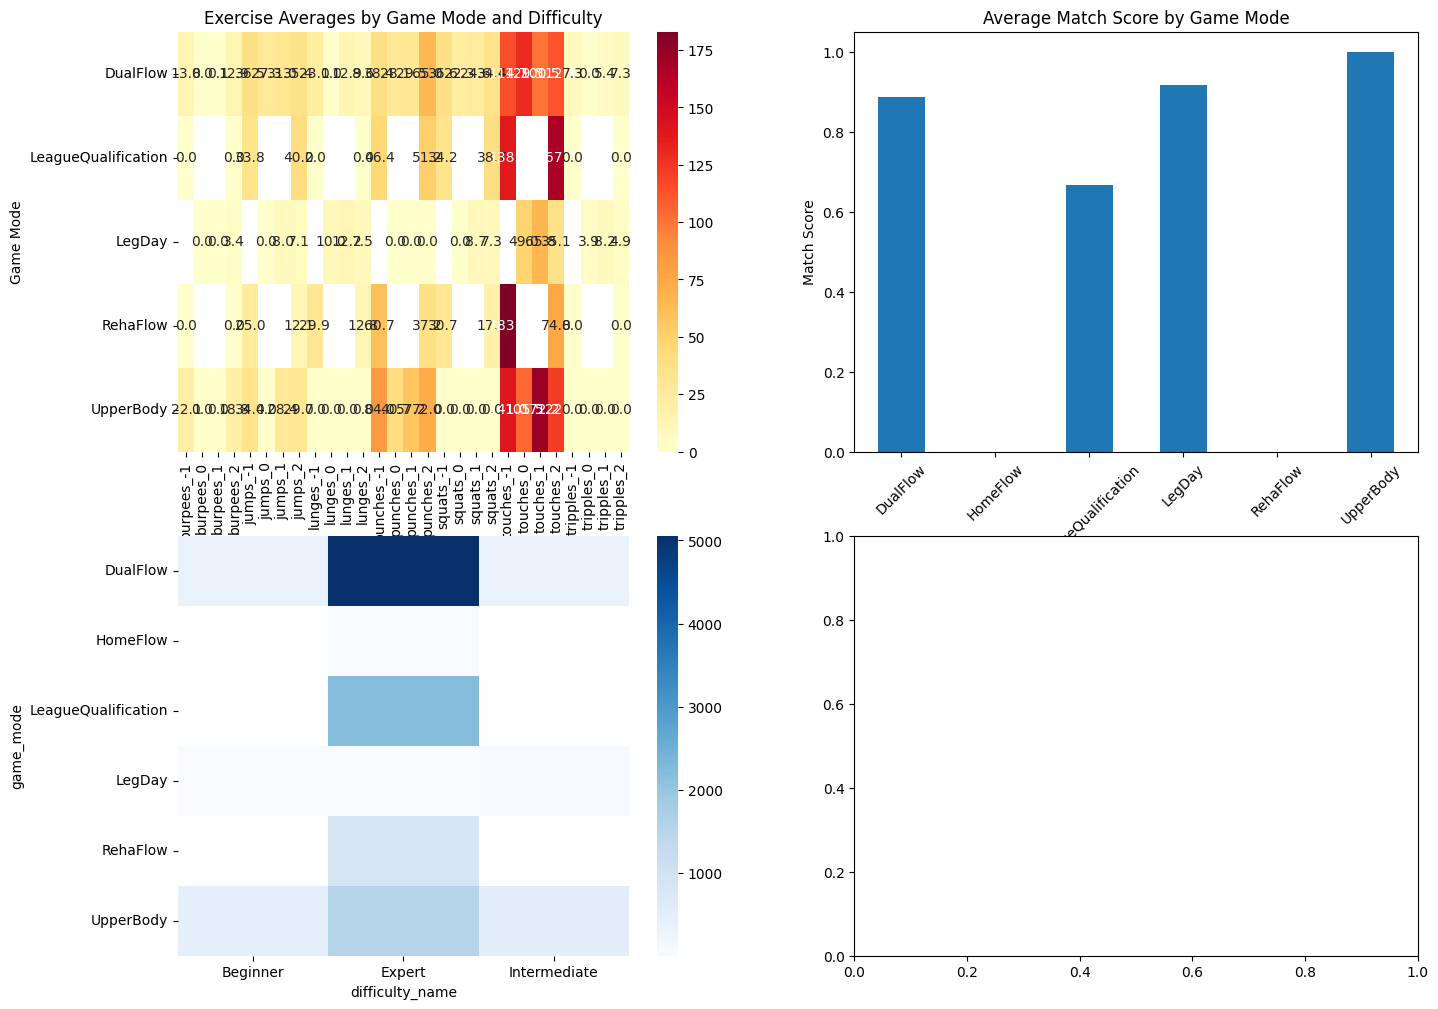

In [5]:
# Step 4: Create visualization of the mapping analysis
if patterns_df is not None and mapping_results is not None:
    # Create a comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heatmap of exercise averages by game mode and difficulty
    pivot_data = patterns_df.pivot_table(
        index='game_mode', 
        columns='difficulty', 
        values=['avg_touches', 'avg_punches', 'avg_jumps', 'avg_squats', 
                'avg_tripples', 'avg_lunges', 'avg_burpees'],
        aggfunc='mean'
    )
    
    # Flatten column names for better display
    pivot_data.columns = [f'{col[0].replace("avg_", "")}_{col[1]}' for col in pivot_data.columns]
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Exercise Averages by Game Mode and Difficulty')
    axes[0,0].set_xlabel('Exercise_Difficulty')
    axes[0,0].set_ylabel('Game Mode')
    
    # 2. Match scores by game mode
    match_scores = mapping_results.groupby('game_mode')['match_score'].mean()
    match_scores.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Average Match Score by Game Mode')
    axes[0,1].set_ylabel('Match Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Workout counts by game mode and difficulty
    workout_counts = mapping_results.pivot_table(
        index='game_mode', 
        columns='difficulty_name', 
        values='workout_count', 
        aggfunc='sum'
    )
    
    sns.heatmap(workout_counts, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Workout Counts by Game Mode and Difficulty')
    axes[1,0].set_xlabel('Difficulty Level')
    axes[1,0].set_ylabel('Game Mode')
    
    # 4. Match scores by difficulty level
    difficulty_scores = mapping_results.groupby('difficulty_name')['match_score'].mean()
    difficulty_scores.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Average Match Score by Difficulty Level')
    axes[1,1].set_ylabel('Match Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [6]:
# Step 5: Generate the final summary table as requested
def generate_summary_table(mapping_results):
    """
    Generate the final summary table showing exercise assignments per game mode and difficulty
    """
    # Create summary table
    summary_data = []
    
    # Group by game mode and difficulty
    for game_mode in mapping_results['game_mode'].unique():
        game_data = mapping_results[mapping_results['game_mode'] == game_mode]
        
        # Sort by difficulty for consistent ordering
        game_data = game_data.sort_values('difficulty_num')
        
        beginner_exercises = ""
        intermediate_exercises = ""
        expert_exercises = ""
        
        for idx, row in game_data.iterrows():
            if row['difficulty_name'] == 'Beginner':
                beginner_exercises = row['actual_exercises']
            elif row['difficulty_name'] == 'Intermediate':
                intermediate_exercises = row['actual_exercises']
            elif row['difficulty_name'] == 'Expert':
                expert_exercises = row['actual_exercises']
        
        summary_data.append({
            'Game Mode': game_mode,
            'Beginner Exercises': beginner_exercises,
            'Intermediate Exercises': intermediate_exercises,
            'Expert Exercises': expert_exercises
        })
    
    return pd.DataFrame(summary_data)

# Generate the summary table
if mapping_results is not None:
    summary_table = generate_summary_table(mapping_results)
    
    print("FINAL SUMMARY TABLE:")
    print("Exercise Assignments per Game Mode and Difficulty")
    print("=" * 80)
    display(summary_table)
    
    # Also create a more detailed version with match scores
    print("\nDETAILED ANALYSIS WITH MATCH SCORES:")
    print("=" * 80)
    
    detailed_summary = mapping_results.pivot_table(
        index='game_mode',
        columns='difficulty_name',
        values=['actual_exercises', 'expected_exercises', 'match_score'],
        aggfunc='first'
    )
    
    display(detailed_summary)


FINAL SUMMARY TABLE:
Exercise Assignments per Game Mode and Difficulty


,Game Mode,Beginner Exercises,Intermediate Exercises,Expert Exercises
0,DualFlow,"touches, punches, jumps, squats","touches, punches, jumps, squats, tripples, lunges","touches, punches, jumps, squats, tripples, lun..."
1,HomeFlow,,,
2,LeagueQualification,,,"touches, punches, jumps, squats"
3,LegDay,"touches, tripples, lunges","touches, jumps, squats, tripples, lunges","touches, jumps, squats, tripples, lunges, burpees"
4,RehaFlow,,,"touches, punches, jumps, squats, lunges"
5,UpperBody,"touches, punches","touches, punches, jumps","touches, punches, jumps, burpees"



DETAILED ANALYSIS WITH MATCH SCORES:


actual_exercises  \
difficulty_name                             Beginner   
game_mode                                              
DualFlow             touches, punches, jumps, squats   
HomeFlow                                         NaN   
LeagueQualification                              NaN   
LegDay                     touches, tripples, lunges   
RehaFlow                                         NaN   
UpperBody                           touches, punches   

                                                                        \
difficulty_name                                                 Expert   
game_mode                                                                
DualFlow             touches, punches, jumps, squats, tripples, lun...   
HomeFlow                                                                 
LeagueQualification                    touches, punches, jumps, squats   
LegDay               touches, jumps, squats, tripples, lunges, burpees   
RehaFlow                       touches, punches, jumps, squats, lunges   
UpperBody                             touches, punches, jumps, burpees   

                                                                        \
difficulty_name                                           Intermediate   
game_mode                                                                
DualFlow             touches, punches, jumps, squats, tripples, lunges   
HomeFlow                                                           NaN   
LeagueQualification                                                NaN   
LegDay                        touches, jumps, squats, tripples, lunges   
RehaFlow                                                           NaN   
UpperBody                                      touches, punches, jumps   

                                     expected_exercises  \
difficulty_name                                Beginner   
game_mode                                                 
DualFlow                touches, punches, jumps, squats   
HomeFlow                                            NaN   
LeagueQualification                                 NaN   
LegDay               touches, punches, lunges, tripples   
RehaFlow                                            NaN   
UpperBody                              touches, punches   

                                                                        \
difficulty_name                                                 Expert   
game_mode                                                                
DualFlow             touches, punches, jumps, squats, tripples, bur...   
HomeFlow                                                                 
LeagueQualification  touches, punches, jumps, squats, tripples, bur...   
LegDay               touches, lunges, tripples, jumps, squats, burpees   
RehaFlow                                                                 
UpperBody                             touches, punches, jumps, burpees   

                                                               match_score  \
difficulty_name                                   Intermediate    Beginner   
game_mode                                                                    
DualFlow             touches, punches, jumps, squats, tripples        1.00   
HomeFlow                                                   NaN         NaN   
LeagueQualification                                        NaN         NaN   
LegDay                touches, lunges, tripples, jumps, squats        0.75   
RehaFlow                                                   NaN         NaN   
UpperBody                              touches, punches, jumps        1.00   

                                            
difficulty_name        Expert Intermediate  
game_mode                                   
DualFlow             0.857143     0.833333  
HomeFlow             0.000000          NaN  
LeagueQualification  0.666667          NaN  
LegDay               1.00

In [7]:
# Step 6: Save the expected vs actual exercise mapping analysis as CSV
if mapping_results is not None:
    # Create a more detailed CSV with all the analysis results
    csv_data = mapping_results.copy()
    
    # Add additional columns for better analysis
    csv_data['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    csv_data['match_percentage'] = (csv_data['match_score'] * 100).round(2)
    
    # Reorder columns for better readability
    column_order = [
        'game_mode', 
        'difficulty_num', 
        'difficulty_name',
        'expected_exercises',
        'actual_exercises', 
        'match_score',
        'match_percentage',
        'workout_count',
        'analysis_date'
    ]
    
    csv_data = csv_data[column_order]
    
    # Save to CSV
    csv_filename = 'expected_vs_actual_exercise_mapping.csv'
    csv_data.to_csv(csv_filename, index=False)
    
    print(f"✅ Analysis saved to: {csv_filename}")
    print(f"📊 Total records: {len(csv_data)}")
    print(f"🎮 Game modes analyzed: {csv_data['game_mode'].nunique()}")
    print(f"📈 Average match score: {csv_data['match_score'].mean():.2f}")
    
    # Also create a summary CSV
    summary_csv = summary_table.copy()
    summary_csv['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    
    summary_filename = 'game_mode_exercise_summary.csv'
    summary_csv.to_csv(summary_filename, index=False)
    
    print(f"✅ Summary table saved to: {summary_filename}")
    
    # Show first few rows of what was saved
    print(f"\n📋 Preview of {csv_filename}:")
    print("=" * 80)
    display(csv_data.head())
    
    print(f"\n📋 Preview of {summary_filename}:")
    print("=" * 80)
    display(summary_csv)


✅ Analysis saved to: expected_vs_actual_exercise_mapping.csv
📊 Total records: 16
🎮 Game modes analyzed: 6
📈 Average match score: 0.73
✅ Summary table saved to: game_mode_exercise_summary.csv

📋 Preview of expected_vs_actual_exercise_mapping.csv:


,game_mode,difficulty_num,difficulty_name,expected_exercises,actual_exercises,match_score,match_percentage,workout_count,analysis_date
0,DualFlow,-1,Expert,"touches, punches, jumps, squats, tripples, bur...","touches, punches, jumps, squats, tripples, lun...",0.857143,85.71,2425,2025-07-07 11:38:57
1,DualFlow,0,Beginner,"touches, punches, jumps, squats","touches, punches, jumps, squats",1.000000,100.00,384,2025-07-07 11:38:57
2,DualFlow,1,Intermediate,"touches, punches, jumps, squats, tripples","touches, punches, jumps, squats, tripples, lunges",0.833333,83.33,338,2025-07-07 11:38:57
3,DualFlow,2,Expert,"touches, punches, jumps, squats, tripples, bur...","touches, punches, jumps, squats, tripples, lun...",0.857143,85.71,2633,2025-07-07 11:38:57
4,HomeFlow,2,Expert,,,0.000000,0.00,10,2025-07-07 11:38:57



📋 Preview of game_mode_exercise_summary.csv:


,Game Mode,Beginner Exercises,Intermediate Exercises,Expert Exercises,analysis_date
0,DualFlow,"touches, punches, jumps, squats","touches, punches, jumps, squats, tripples, lunges","touches, punches, jumps, squats, tripples, lun...",2025-07-07 11:38:57
1,HomeFlow,,,,2025-07-07 11:38:57
2,LeagueQualification,,,"touches, punches, jumps, squats",2025-07-07 11:38:57
3,LegDay,"touches, tripples, lunges","touches, jumps, squats, tripples, lunges","touches, jumps, squats, tripples, lunges, burpees",2025-07-07 11:38:57
4,RehaFlow,,,"touches, punches, jumps, squats, lunges",2025-07-07 11:38:57
5,UpperBody,"touches, punches","touches, punches, jumps","touches, punches, jumps, burpees",2025-07-07 11:38:57


In [ ]:
# Debug: Check for LegDay game mode specifically
def debug_legday_analysis():
    """
    Debug function to specifically check for LegDay game mode
    """
    try:
        conn = mysql.connector.connect(**config)
        
        # Check all game modes in the database
        all_modes_query = """
        SELECT DISTINCT wp.name as game_mode, COUNT(w.id) as workout_count
        FROM WorkoutPresets wp
        LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
        WHERE w.completedWorkout = 1 AND w.score > 0
        GROUP BY wp.name
        ORDER BY workout_count DESC
        """
        
        all_modes_df = pd.read_sql(all_modes_query, conn)
        
        print("🔍 ALL GAME MODES IN DATABASE:")
        print("=" * 50)
        display(all_modes_df)
        
        # Check specifically for LegDay
        legday_query = """
        SELECT 
            wp.name as game_mode,
            wp.exercisePool,
            rc.difficulty,
            COUNT(w.id) as workout_count
        FROM WorkoutPresets wp
        LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
        LEFT JOIN RaceConfigs rc ON w.id = rc.workoutId
        WHERE wp.name = 'LegDay' AND w.completedWorkout = 1 AND w.score > 0
        GROUP BY wp.name, wp.exercisePool, rc.difficulty
        ORDER BY rc.difficulty
        """
        
        legday_df = pd.read_sql(legday_query, conn)
        
        print("\n🦵 LEGDAY SPECIFIC ANALYSIS:")
        print("=" * 50)
        if len(legday_df) > 0:
            display(legday_df)
            
            # Get exercise averages for LegDay
            legday_exercises_query = """
            SELECT
                wp.name as game_mode,
                rc.difficulty,
                AVG(w.totalTouches) as avg_touches,
                AVG(w.totalPunches) as avg_punches,
                AVG(w.totalJumps) as avg_jumps,
                AVG(w.totalSquats) as avg_squats,
                AVG(w.totalTripples) as avg_tripples,
                AVG(w.totalLunges) as avg_lunges,
                AVG(w.totalBurpees) as avg_burpees,
                COUNT(w.id) as workout_count
            FROM Workouts w
            JOIN WorkoutPresets wp ON w.workoutPresetId = wp.id
            JOIN RaceConfigs rc ON w.id = rc.workoutId
            WHERE wp.name = 'LegDay' AND w.completedWorkout = 1 AND w.score > 0
            GROUP BY wp.name, rc.difficulty
            ORDER BY rc.difficulty
            """
            
            legday_exercises_df = pd.read_sql(legday_exercises_query, conn)
            
            print("\n🏃‍♂️ LEGDAY EXERCISE AVERAGES:")
            print("=" * 50)
            display(legday_exercises_df)
            
        else:
            print("❌ No LegDay data found!")
            
            # Check if LegDay exists but with no completed workouts
            legday_exists_query = """
            SELECT wp.name, wp.exercisePool, COUNT(w.id) as total_workouts
            FROM WorkoutPresets wp
            LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
            WHERE wp.name = 'LegDay'
            GROUP BY wp.name, wp.exercisePool
            """
            
            legday_exists_df = pd.read_sql(legday_exists_query, conn)
            
            if len(legday_exists_df) > 0:
                print("⚠️  LegDay exists but may have no completed workouts:")
                display(legday_exists_df)
            else:
                print("❌ LegDay game mode does not exist in the database!")
        
        conn.close()
        
        return legday_df if len(legday_df) > 0 else None
        
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return None

# Run the debug analysis
legday_data = debug_legday_analysis()


In [ ]:
# Fix the expected patterns mapping to match actual database game mode names
def create_corrected_expected_patterns():
    """
    Create corrected expected patterns based on actual database game mode names
    """
    # First, let's see what game modes actually exist in our data
    if patterns_df is not None:
        actual_game_modes = patterns_df['game_mode'].unique()
        print("🎮 ACTUAL GAME MODES IN DATABASE:")
        print("=" * 50)
        for mode in actual_game_modes:
            print(f"- {mode}")
        
        # Updated expected patterns to match database names
        corrected_expected_patterns = {
            'DualFlow': {
                'Beginner': ['touches', 'punches', 'jumps', 'squats'],
                'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples'],
                'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
            },
            'UpperBody': {
                'Beginner': ['touches', 'punches'],
                'Intermediate': ['touches', 'punches', 'jumps'],
                'Expert': ['touches', 'punches', 'jumps', 'burpees']
            },
            'LegDay': {  # This should match the database name
                'Beginner': ['touches', 'punches', 'lunges', 'tripples'],
                'Intermediate': ['touches', 'lunges', 'tripples', 'jumps', 'squats'],
                'Expert': ['touches', 'lunges', 'tripples', 'jumps', 'squats', 'burpees']
            },
            'LeagueQualification': {  # Competition Mode
                'Beginner': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees'],
                'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees'],
                'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
            },
            'RehaFlow': {  # Rehabilitation mode - assuming similar to DualFlow but lighter
                'Beginner': ['touches', 'punches'],
                'Intermediate': ['touches', 'punches', 'jumps'],
                'Expert': ['touches', 'punches', 'jumps', 'squats']
            },
            'HomeFlow': {  # Home workout mode - assuming full exercises
                'Beginner': ['touches', 'punches', 'jumps', 'squats'],
                'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples'],
                'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
            }
        }
        
        print(f"\n✅ CORRECTED EXPECTED PATTERNS:")
        print("=" * 50)
        for game_mode, difficulties in corrected_expected_patterns.items():
            print(f"\n{game_mode}:")
            for difficulty, exercises in difficulties.items():
                print(f"  {difficulty}: {exercises}")
        
        return corrected_expected_patterns
    
    return None

# Create corrected patterns
corrected_patterns = create_corrected_expected_patterns()


In [ ]:
# Re-run the analysis with corrected patterns including LegDay
def rerun_corrected_analysis(patterns_df, corrected_patterns):
    """
    Re-run the mapping analysis with corrected expected patterns
    """
    if patterns_df is None or corrected_patterns is None:
        print("❌ Cannot run analysis - missing data")
        return None
    
    # Function to determine which exercises are "present" in actual data
    def get_present_exercises(row, threshold=1.0):
        present = []
        if row['avg_touches'] > threshold: present.append('touches')
        if row['avg_punches'] > threshold: present.append('punches')
        if row['avg_jumps'] > threshold: present.append('jumps')
        if row['avg_squats'] > threshold: present.append('squats')
        if row['avg_tripples'] > threshold: present.append('tripples')
        if row['avg_lunges'] > threshold: present.append('lunges')
        if row['avg_burpees'] > threshold: present.append('burpees')
        return present
    
    # Function to map difficulty numbers to names
    def map_difficulty_to_name(difficulty):
        if difficulty == 0:
            return 'Beginner'
        elif difficulty == 1:
            return 'Intermediate'
        elif difficulty in [-1, 2]:
            return 'Expert'
        else:
            return 'Unknown'
    
    # Analyze each game mode
    results = []
    
    for game_mode in patterns_df['game_mode'].unique():
        game_data = patterns_df[patterns_df['game_mode'] == game_mode]
        
        for idx, row in game_data.iterrows():
            difficulty_num = row['difficulty']
            difficulty_name = map_difficulty_to_name(difficulty_num)
            
            # Get actual exercises present
            actual_exercises = get_present_exercises(row)
            
            # Get expected exercises for this game mode and difficulty
            expected_exercises = []
            if game_mode in corrected_patterns and difficulty_name in corrected_patterns[game_mode]:
                expected_exercises = corrected_patterns[game_mode][difficulty_name]
            
            # Calculate match score using Jaccard similarity
            if expected_exercises:
                overlap = len(set(actual_exercises) & set(expected_exercises))
                total = len(set(actual_exercises) | set(expected_exercises))
                match_score = overlap / total if total > 0 else 0
            else:
                match_score = 0
            
            results.append({
                'game_mode': game_mode,
                'difficulty_num': difficulty_num,
                'difficulty_name': difficulty_name,
                'actual_exercises': ', '.join(actual_exercises),
                'expected_exercises': ', '.join(expected_exercises),
                'match_score': match_score,
                'match_percentage': round(match_score * 100, 2),
                'workout_count': row['workout_count'],
                'overlap_count': len(set(actual_exercises) & set(expected_exercises)) if expected_exercises else 0,
                'total_unique_count': len(set(actual_exercises) | set(expected_exercises)) if expected_exercises else 0
            })
    
    return pd.DataFrame(results)

# Run corrected analysis
corrected_mapping_results = rerun_corrected_analysis(patterns_df, corrected_patterns)

if corrected_mapping_results is not None:
    print("🔄 CORRECTED MAPPING ANALYSIS RESULTS:")
    print("=" * 70)
    display(corrected_mapping_results)
    
    # Show LegDay specifically
    legday_results = corrected_mapping_results[corrected_mapping_results['game_mode'] == 'LegDay']
    if len(legday_results) > 0:
        print("\n🦵 LEGDAY SPECIFIC RESULTS:")
        print("=" * 50)
        display(legday_results)
    else:
        print("\n❌ LegDay still not found in results")
    
    # Show match score statistics
    print("\n📊 MATCH SCORE STATISTICS:")
    print("=" * 50)
    match_stats = corrected_mapping_results.groupby('game_mode').agg({
        'match_score': ['mean', 'min', 'max'],
        'workout_count': 'sum'
    }).round(3)
    display(match_stats)


In [ ]:
# Save the corrected analysis results to CSV files
if corrected_mapping_results is not None:
    # Save detailed analysis
    corrected_mapping_results['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Reorder columns for better readability
    column_order = [
        'game_mode', 
        'difficulty_num', 
        'difficulty_name',
        'expected_exercises',
        'actual_exercises', 
        'match_score',
        'match_percentage',
        'overlap_count',
        'total_unique_count',
        'workout_count',
        'analysis_date'
    ]
    
    corrected_csv_data = corrected_mapping_results[column_order]
    
    # Save to CSV
    corrected_csv_filename = 'corrected_exercise_mapping_analysis.csv'
    corrected_csv_data.to_csv(corrected_csv_filename, index=False)
    
    print(f"✅ CORRECTED analysis saved to: {corrected_csv_filename}")
    print(f"📊 Total records: {len(corrected_csv_data)}")
    print(f"🎮 Game modes analyzed: {corrected_csv_data['game_mode'].nunique()}")
    print(f"📈 Average match score: {corrected_csv_data['match_score'].mean():.2f}")
    
    # Save average exercise counts as a separate CSV
    if patterns_df is not None:
        exercise_averages = patterns_df.copy()
        exercise_averages['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Round exercise averages for readability
        exercise_cols = ['avg_touches', 'avg_punches', 'avg_jumps', 'avg_squats', 
                        'avg_tripples', 'avg_lunges', 'avg_burpees']
        
        for col in exercise_cols:
            exercise_averages[col] = exercise_averages[col].round(2)
        
        averages_filename = 'exercise_averages_by_game_mode_difficulty.csv'
        exercise_averages.to_csv(averages_filename, index=False)
        
        print(f"✅ Exercise averages saved to: {averages_filename}")
    
    # Show preview of saved files
    print(f"\n📋 Preview of {corrected_csv_filename}:")
    print("=" * 80)
    display(corrected_csv_data.head())
    
    if patterns_df is not None:
        print(f"\n📋 Preview of {averages_filename}:")
        print("=" * 80)
        display(exercise_averages.head())
    
    # Summary of findings
    print(f"\n🔍 KEY FINDINGS:")
    print("=" * 50)
    
    # Check if LegDay is in the results
    legday_count = len(corrected_csv_data[corrected_csv_data['game_mode'] == 'LegDay'])
    print(f"🦵 LegDay records found: {legday_count}")
    
    # Best and worst matches
    best_match = corrected_csv_data.loc[corrected_csv_data['match_score'].idxmax()]
    worst_match = corrected_csv_data.loc[corrected_csv_data['match_score'].idxmin()]
    
    print(f"🏆 Best match: {best_match['game_mode']} - {best_match['difficulty_name']} ({best_match['match_percentage']:.1f}%)")
    print(f"⚠️  Worst match: {worst_match['game_mode']} - {worst_match['difficulty_name']} ({worst_match['match_percentage']:.1f}%)")
    
    # Game mode with most data
    game_mode_counts = corrected_csv_data.groupby('game_mode')['workout_count'].sum().sort_values(ascending=False)
    print(f"📊 Most data: {game_mode_counts.index[0]} ({game_mode_counts.iloc[0]:,} workouts)")
    
else:
    print("❌ No corrected results to save")


In [8]:
# Analyze RehaFlow game mode specifically
def analyze_rehaflow_exercises():
    """
    Detailed analysis of RehaFlow game mode exercises
    """
    try:
        conn = mysql.connector.connect(**config)
        
        # Get RehaFlow exercise pool from WorkoutPresets
        rehaflow_preset_query = """
        SELECT 
            wp.name as game_mode,
            wp.exercisePool,
            COUNT(w.id) as total_workouts
        FROM WorkoutPresets wp
        LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
        WHERE wp.name = 'RehaFlow'
        GROUP BY wp.name, wp.exercisePool
        """
        
        rehaflow_preset_df = pd.read_sql(rehaflow_preset_query, conn)
        
        print("🏥 REHAFLOW EXERCISE POOL FROM DATABASE:")
        print("=" * 60)
        display(rehaflow_preset_df)
        
        if len(rehaflow_preset_df) > 0:
            exercise_pool = rehaflow_preset_df.iloc[0]['exercisePool']
            if exercise_pool:
                exercises = exercise_pool.split(';')
                print(f"\n📋 RehaFlow Exercise Pool: {exercises}")
            else:
                print("\n❌ No exercise pool defined for RehaFlow")
        
        # Get actual exercise performance data for RehaFlow
        rehaflow_performance_query = """
        SELECT
            wp.name as game_mode,
            rc.difficulty,
            AVG(w.totalTouches) as avg_touches,
            AVG(w.totalPunches) as avg_punches,
            AVG(w.totalJumps) as avg_jumps,
            AVG(w.totalSquats) as avg_squats,
            AVG(w.totalTripples) as avg_tripples,
            AVG(w.totalLunges) as avg_lunges,
            AVG(w.totalBurpees) as avg_burpees,
            COUNT(w.id) as workout_count,
            AVG(w.score) as avg_score,
            AVG(w.measuredDuration) as avg_duration_seconds
        FROM Workouts w
        JOIN WorkoutPresets wp ON w.workoutPresetId = wp.id
        JOIN RaceConfigs rc ON w.id = rc.workoutId
        WHERE wp.name = 'RehaFlow' AND w.completedWorkout = 1 AND w.score > 0
        GROUP BY wp.name, rc.difficulty
        ORDER BY rc.difficulty
        """
        
        rehaflow_performance_df = pd.read_sql(rehaflow_performance_query, conn)
        
        print(f"\n🏃‍♂️ REHAFLOW ACTUAL EXERCISE PERFORMANCE:")
        print("=" * 60)
        if len(rehaflow_performance_df) > 0:
            display(rehaflow_performance_df.round(2))
            
            # Analyze which exercises are actually performed (threshold > 1.0)
            print(f"\n📊 REHAFLOW EXERCISES ANALYSIS BY DIFFICULTY:")
            print("=" * 60)
            
            for idx, row in rehaflow_performance_df.iterrows():
                difficulty = row['difficulty']
                print(f"\n🎯 Difficulty {difficulty}:")
                print(f"   Workouts: {row['workout_count']}")
                print(f"   Avg Score: {row['avg_score']:,.0f}")
                print(f"   Avg Duration: {row['avg_duration_seconds']/60:.1f} minutes")
                
                # List exercises performed (above threshold)
                exercises_performed = []
                if row['avg_touches'] > 1.0:
                    exercises_performed.append(f"Touches ({row['avg_touches']:.1f})")
                if row['avg_punches'] > 1.0:
                    exercises_performed.append(f"Punches ({row['avg_punches']:.1f})")
                if row['avg_jumps'] > 1.0:
                    exercises_performed.append(f"Jumps ({row['avg_jumps']:.1f})")
                if row['avg_squats'] > 1.0:
                    exercises_performed.append(f"Squats ({row['avg_squats']:.1f})")
                if row['avg_tripples'] > 1.0:
                    exercises_performed.append(f"Tripples ({row['avg_tripples']:.1f})")
                if row['avg_lunges'] > 1.0:
                    exercises_performed.append(f"Lunges ({row['avg_lunges']:.1f})")
                if row['avg_burpees'] > 1.0:
                    exercises_performed.append(f"Burpees ({row['avg_burpees']:.1f})")
                
                print(f"   Exercises: {', '.join(exercises_performed) if exercises_performed else 'None above threshold'}")
            
            # Compare with other game modes
            print(f"\n🔄 COMPARISON WITH OTHER GAME MODES:")
            print("=" * 60)
            
            comparison_query = """
            SELECT
                wp.name as game_mode,
                AVG(w.totalTouches) as avg_touches,
                AVG(w.totalPunches) as avg_punches,
                AVG(w.totalJumps) as avg_jumps,
                AVG(w.totalSquats) as avg_squats,
                AVG(w.totalTripples) as avg_tripples,
                AVG(w.totalLunges) as avg_lunges,
                AVG(w.totalBurpees) as avg_burpees,
                COUNT(w.id) as workout_count
            FROM Workouts w
            JOIN WorkoutPresets wp ON w.workoutPresetId = wp.id
            JOIN RaceConfigs rc ON w.id = rc.workoutId
            WHERE w.completedWorkout = 1 AND w.score > 0
            GROUP BY wp.name
            ORDER BY workout_count DESC
            """
            
            comparison_df = pd.read_sql(comparison_query, conn)
            display(comparison_df.round(2))
            
        else:
            print("❌ No RehaFlow performance data found!")
        
        conn.close()
        
        return rehaflow_performance_df if len(rehaflow_performance_df) > 0 else None
        
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return None

# Run RehaFlow analysis
rehaflow_data = analyze_rehaflow_exercises()


🏥 REHAFLOW EXERCISE POOL FROM DATABASE:


,game_mode,exercisePool,total_workouts
0,RehaFlow,touches;punches;jumps;squats;lunges,1033



📋 RehaFlow Exercise Pool: ['touches', 'punches', 'jumps', 'squats', 'lunges']

🏃‍♂️ REHAFLOW ACTUAL EXERCISE PERFORMANCE:


,game_mode,difficulty,avg_touches,avg_punches,avg_jumps,avg_squats,avg_tripples,avg_lunges,avg_burpees,workout_count,avg_score,avg_duration_seconds
0,RehaFlow,-1,183.03,60.74,24.98,30.71,0.0,29.92,0.0,712,249298.81,732.94
1,RehaFlow,2,74.78,37.21,12.10,17.70,0.0,12.78,0.0,115,126994.49,360.94



📊 REHAFLOW EXERCISES ANALYSIS BY DIFFICULTY:

🎯 Difficulty -1:
   Workouts: 712
   Avg Score: 249,299
   Avg Duration: 12.2 minutes
   Exercises: Touches (183.0), Punches (60.7), Jumps (25.0), Squats (30.7), Lunges (29.9)

🎯 Difficulty 2:
   Workouts: 115
   Avg Score: 126,994
   Avg Duration: 6.0 minutes
   Exercises: Touches (74.8), Punches (37.2), Jumps (12.1), Squats (17.7), Lunges (12.8)

🔄 COMPARISON WITH OTHER GAME MODES:


,game_mode,avg_touches,avg_punches,avg_jumps,avg_squats,avg_tripples,avg_lunges,avg_burpees,workout_count
0,DualFlow,113.76,48.83,35.13,34.08,6.71,14.82,11.80,5780
1,UpperBody,132.59,63.72,23.64,0.00,0.00,0.00,11.08,2550
2,LeagueQualification,155.88,49.30,37.70,36.94,0.01,0.02,0.04,2201
3,RehaFlow,167.98,57.47,23.19,28.90,0.00,27.53,0.00,827
4,LegDay,54.36,0.00,5.69,6.10,6.31,10.52,0.79,78
5,HomeFlow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
